1. 라이브러리 설정
2. GPU 설정
3. HYPER PARAMETER 설정
4. DATA 준비
5. 모델 설계
6. 모델 훈련
7. 모델 검증

In [87]:
# 라이브러리 설정
from torchvision import datasets
from torchvision import transforms

import cv2
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [73]:
# GPU 설정
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# 병렬 연결

In [74]:
# Hyper parameter 설정
num_epochs = 10
batch_size = 128
num_class = 10
lr = 1e-4


In [75]:
# Data 준비
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_set = datasets.MNIST(root= './data', train=True, download=True, transform=transform_train)
test_set = datasets.MNIST(root= './data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

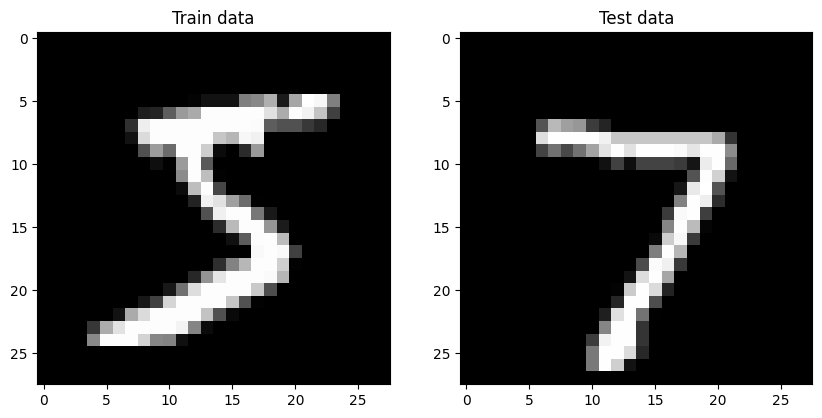

In [76]:
# 이미지 샘플 출력
plt.figure(figsize = (10,10))
# 사진 사이즈 정의
plt.subplot(1,2,1), plt.imshow(train_set[0][0].squeeze(), 'gray'), plt.title('Train data')
plt.subplot(1,2,2), plt.imshow(test_set[0][0].squeeze(), 'gray'), plt.title('Test data')
# subplot 사이즈(사이즈 위치, 배율, n번째), imshow(~몇번째 정하기)
# sample 출력

plt.show()

In [77]:
# GPU 설정
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')


In [78]:
#모델 정의 
class LeNet5(nn.Module):
    #모델 구조 선언
    def __init__(self, num_class):
        super().__init__()
        #Convolution Block
        
        self.backbone = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=0, padding_mode='zeros'),
                                      nn.Tanh(),
                                      nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
                                      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1), padding=0, padding_mode='zeros'), #인풋채널6
                                      nn.Tanh(),
                                      nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
                                      nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5), stride=(1, 1), padding=0, padding_mode='zeros'), #백본끝
                                      nn.Tanh()
                                      )
        # MNIST가 Gray 채널이라 in_channels가 1이다.
        # in과 out을 맞추자. / kernel, stride, padding 등을 먹인다. padding mode 를 zeros로 해서 패딩을 걸어도 0으로 둔다.

        #classifier
        self.classifier = nn.Sequential(nn.Linear(in_features=120, out_features=84),
                                        nn.Tanh(),
                                        nn.Linear(in_features=84, out_features=num_class))
        # classifier가 입력이 120인 게, conv out이 120이기 때문.

    def forward(self, image):
        feature = self.backbone(image)
        feature - feature.view(feature.shape[0], -1) # 플랫튼과 비슷하다...? = 그럼 이 view는 flatten?
        pred = self.classifier(feature)
        return pred
    
    # mlp와 forward가 다르다.
    # view의 -1은 동일하다.
        # def forward(self,x):
        # x = x.view(-1, 784)
        # # print(x.view(2,784))
        # x = torch.sigmoid(self.linear1(x))
        # x = torch.sigmoid(self.linear2(x))
        # x = torch.sigmoid(self.linear3(x))
        # x = torch.sigmoid(self.linear4(x))
        # x = torch.sigmoid(self.linear5(x))
        # x = torch.sigmoid(self.linear6(x))
        # x = torch.sigmoid(self.linear7(x))

In [79]:
lenet5 = LeNet5(10).to(device)
#lenet5 = LeNet5(num_class).to(device)


In [80]:
# custom 모델 정의
class MyModel(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        # 1st Conv. block
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=0, padding_mode='zeros')
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=0, padding_mode='zeros')
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)            

        # 2nd Conv. block
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=0, padding_mode='zeros')
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=0, padding_mode='zeros')
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)

        #classifier
        self.classifier = nn.Linear(in_features=1024, out_features=num_class)
        # linear 1개 정리

    def forward(self, image):
        # 1st Block
        f1 = nn.ReLU()(self.conv1_1(image))
        f1 = nn.ReLU()(self.conv1_2(f1))
        f1 = self.pool1(f1)
        # 이미지를 넣은 conv 레이어를 Relu에 넣고, 나온 것을 conv 레이어 넣고 풀링을 한다.
        # conv - relu - conv - relu - pool

        # 2nd Block
        f2 = nn.ReLU()(self.conv2_1(f1))
        f2 = nn.ReLU()(self.conv2_2(f2))
        f2 =self.pool2(f2)
        # 왜 ReLU는 () 밖에 init 변수를 넣고 있나요?


        # Flatten
        f2 = f2.view(f2.shape[0], -1)

        #classifier
        # pred = nn.Sigmoid()(self.classifier(f2))
        pred = self.classifier(f2)
        return pred
        

In [81]:
mymodel = MyModel(num_class=num_class).to(device)

In [82]:
# 학습률 설정
lr = 0.1

# SGD
optimizer = optim.SGD(mymodel.parameters(), lr=lr)

# SGD with Momentum 
# optimizer = optim.SGD(mymodel.parameters(), lr=lr, momentum= 0.9)

#RMSprop
# optimizer = optim.RMSprop(mymodel.parameters(), lr=lr, alpha=0.99)

#Adam
# optimizer = optim.Adam(mymodel.parameters(), lr=lr, betas=(0.9, 0.999))

#Cross Entropy Loss
criterion = nn.CrossEntropyLoss().to(device)

# 텐서보드 기록자 생성
writer = SummaryWriter(f'log/mymodel') 
# 그래프에 따라 진행상황 볼 수 있음.

In [90]:
# 저장 위치 설정
ckpt_path = './checkpoint'
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)

# 최소 loss
best_loss = 9999

# 모델 학습 모드

# 에폭만큼 반복
for epoch in range(num_epochs):
    print (f'Epoch {epoch}:')
    mymodel.train() # drop out 작동
    train_loss = 0

    # 모델 학습
    print(f'Training model...')

    # dataloader를 통한 데이터 불러오기
    for image, label in tqdm(train_loader):
    # 데이터 연산 위치 지정 (GPU or CPU)
        image = image.to(device)
        label = label.to(device)
        pred = mymodel(image)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 최종 loss 누적
        train_loss += loss.detach().cpu().numpy()
        # train_loss += loss.item()
    # 학습 loss 기록
    train_loss /= len(train_loader)
    writer.add_scalar("train_loss", train_loss, epoch)
    print(f'Train Loss : {train_loss}\n')

    ###### 모델 평가 ######
    print(f'Evaluating model...')
    accuracy = 0
    test_loss = 0

    # 모델 평가 모드
    mymodel.eval()
    # gradient 계산 차단
    with torch.no_grad():
    # Dataloader로 데이터 불러오기
        for image, label in tqdm(test_loader): #tqdm 진행상황을 실시간으로 볼수있음. 남은반복횟수, 걸리는 시간 확인 가능
            # 데이터 연산 위치 지정 (GPU or CPU)
            image = image.to(device) #cpu 등을 올려놓는다
            label = label.to(device)
            # 모델에 입력 (순전파)
            pred = mymodel(image)
            # Loss 계산
            loss = criterion(pred, label)
            
            # 최종 loss 누적
            test_loss += loss.detach().cpu().numpy()
            # 정답 개수 누적
            corr = (pred.argmax(axis=1) == label).sum()
            accuracy += corr.detach().cpu().numpy()

    # 평가 loss 기록
    test_loss /= len(test_loader)
    writer.add_scalar("test_loss", test_loss, epoch)
    print(f'Test Loss: {test_loss}')
    # 정확도 계산
    accuracy /= len(test_set)
    print(f'Accuracy: {100*accuracy}%\n')
    # 최소 loss가 갱신되면 모델 저장
    if best_loss > test_loss:
        print('Saving model...\n')
        best_loss = test_loss
        torch.save(mymodel.state_dict(), os.path.join(ckpt_path, 'model.ckpt'))
        



Epoch 0:
Training model...


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss : 0.007255154235977405

Evaluating model...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.041870419828663796
Accuracy: 98.99%

Saving model...

Epoch 1:
Training model...


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss : 0.007604808951519851

Evaluating model...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.04440490937984094
Accuracy: 98.89%

Epoch 2:
Training model...


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss : 0.0063267186073652

Evaluating model...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.03930974969890612
Accuracy: 99.05000000000001%

Saving model...

Epoch 3:
Training model...


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss : 0.006770569779239332

Evaluating model...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.054440689112449855
Accuracy: 98.76%

Epoch 4:
Training model...


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss : 0.004898958312756506

Evaluating model...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.04994040281716008
Accuracy: 98.91%

Epoch 5:
Training model...


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss : 0.005751945395697402

Evaluating model...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.04648364891074417
Accuracy: 98.92999999999999%

Epoch 6:
Training model...


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss : 0.004784881681743907

Evaluating model...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.043879165393593524
Accuracy: 99.09%

Epoch 7:
Training model...


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss : 0.0033662712008131874

Evaluating model...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.05090349864217661
Accuracy: 98.94%

Epoch 8:
Training model...


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss : 0.004360723517890711

Evaluating model...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.051118784498914
Accuracy: 98.94%

Epoch 9:
Training model...


  0%|          | 0/469 [00:00<?, ?it/s]

Train Loss : 0.004447185188373022

Evaluating model...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.05668113831200836
Accuracy: 98.89%



In [ ]:

%load_ext tensorboard
%tensorboard --logdir log

In [93]:
# 계층별 feature 출력 함수
def visualize_feature(image):
  # 계층별 feature
  f1 = mymodel.conv1_1(image)
  f2 = mymodel.conv1_2(nn.ReLU()(f1))
  f3 = mymodel.pool1(f2)
  f4 = mymodel.conv2_1(f3)
  f5 = mymodel.conv2_2(nn.ReLU()(f4))
  f6 = mymodel.pool1(f5)

  # image 출력
  plt.figure(figsize=(3, 3))
  plt.subplot(1, 1, 1), plt.title('image'), plt.imshow(image.squeeze().detach().cpu().numpy(), cmap='gray')
  plt.show()

  # f1 feature 출력
  print('====== feature 1 ======')
  print(f'f1 shape: {f1.shape}')
  plt.figure(figsize=(20, 3))
  for i in range(32):
      plt.subplot(2, 16, i+1), plt.imshow(f1[i].squeeze().detach().cpu().numpy(), cmap='gray'), plt.xticks([]), plt.yticks([])
  plt.show()

  # f1 feature 출력
  print('====== feature 3 ======')
  print(f'f3 shape: {f3.shape}')
  plt.figure(figsize=(20, 3))
  for i in range(32):
      plt.subplot(2, 16, i+1), plt.imshow(f3[i].squeeze().detach().cpu().numpy(), cmap='gray'), plt.xticks([]), plt.yticks([])
  plt.show()

  # f1 feature 출력
  print('====== feature 6 ======')
  print(f'f6 shape: {f6.shape}')
  plt.figure(figsize=(20, 5))
  for i in range(64):
      plt.subplot(4, 16, i+1), plt.imshow(f6[i].squeeze().detach().cpu().numpy(), cmap='gray'), plt.xticks([]), plt.yticks([])
  plt.show()

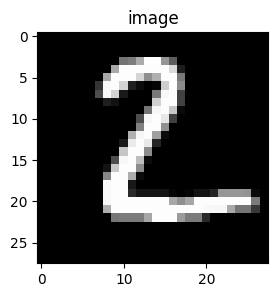

====== feature 1 ======
f1 shape: torch.Size([32, 26, 26])


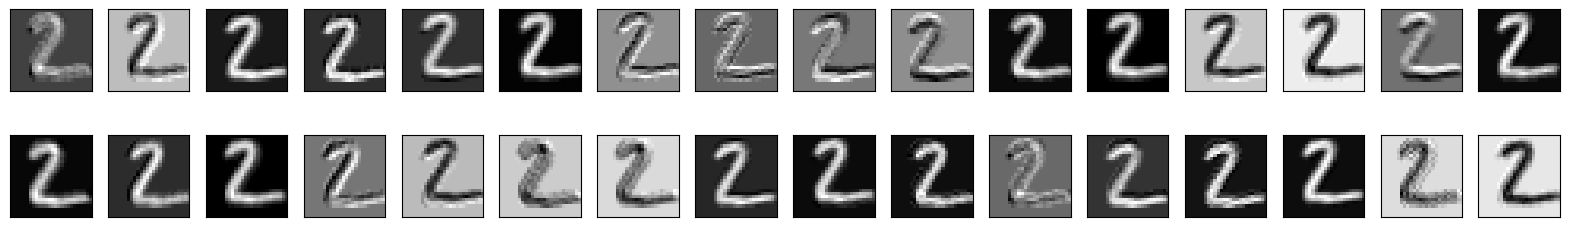

====== feature 3 ======
f3 shape: torch.Size([32, 12, 12])


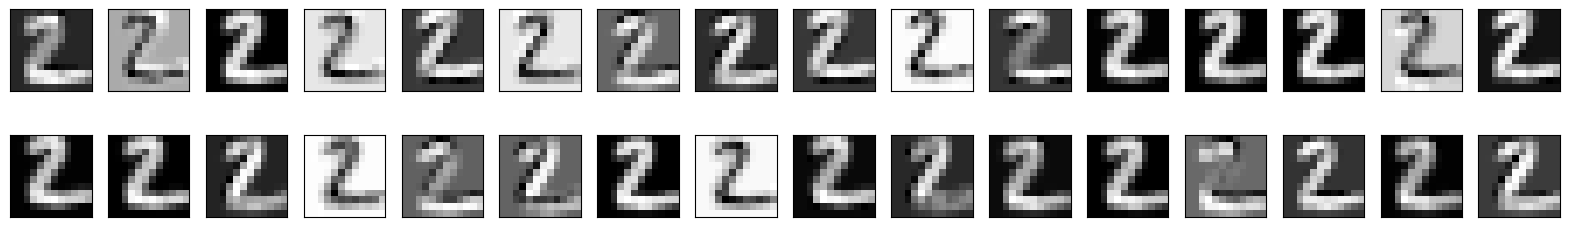

====== feature 6 ======
f6 shape: torch.Size([64, 4, 4])


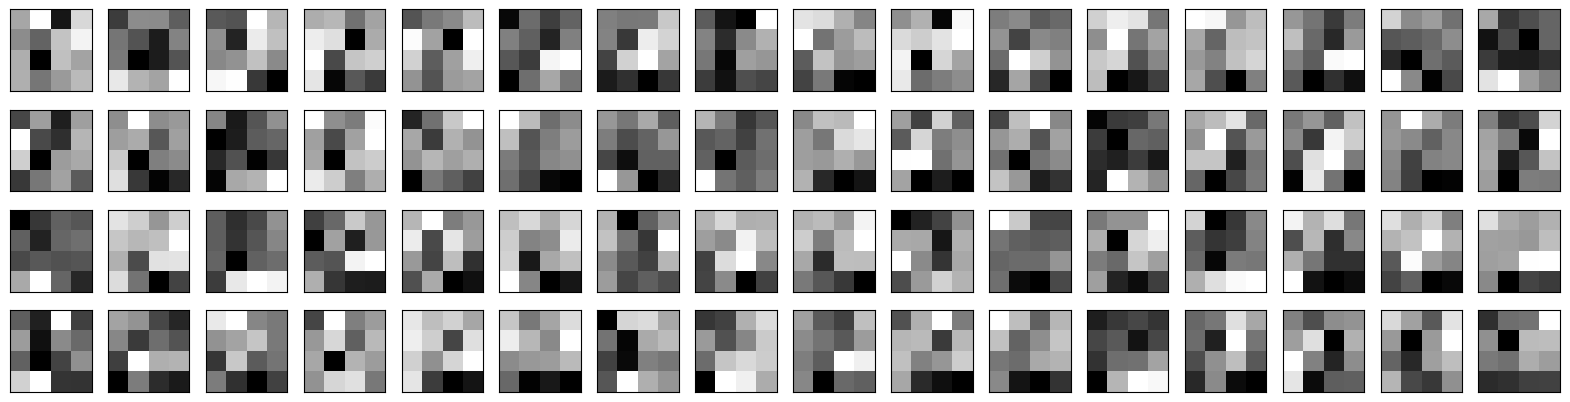

In [94]:
image = test_set.data[1].unsqueeze(0).type(torch.FloatTensor).to(device)
visualize_feature(image)